In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'Times New Roman'
})

#hair cell fluctuation paper: E. Roldan et. al. New J. Phys. 23 083013(2021)
#parameters of the model
lambda1 = 2.8e-6
lambda2 = 10e-6
K_gs = 0.75e-3
K_sp = 0.6e-3
D = 61e-9
S = 0.94
#S = 1
N = 50
kB = 1.38e-23
kBT = 4.143e-21
T = 300
delG = 10*kBT
Teff = 1.5*T
kBTeff = 1.5*kBT

F_max = 40e-12                    #quiescent
A = np.exp((delG + (K_gs*D**2)/(2*N))/kBT)


In [22]:
t1,t2,dt = 0, 10, 10**(-5)
sf = 1/dt 
n = int(round((t2 - t1) / dt))
t = np.linspace(t1,t2,n)
nop = 1
X = np.zeros((n, 2, nop), dtype=float)
Po =  np.zeros((n-1, 1, nop), dtype=float)
F_act =  np.zeros((n-1, 1, nop), dtype=float)


for i in range(n-1):
    Po[i,0,:] = 1/(1 + A*np.exp(-K_gs*D*(X[i,0,:]-X[i,1,:])/(N*kBT)))
    F_act[i,0,:] = F_max*(1 - S*Po[i,0,:])               
    X[i+1,0,:] = X[i,0,:] + dt*(1/lambda1)*(-K_sp*X[i,0,:] + K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(X[i,0,:]-X[i,1,:])/(N*kBT))))-X[i,0,:]+X[i,1,:])) + np.sqrt(dt*2*kBT/lambda1)*np.random.normal(0,1,1)
    X[i+1,1,:] = X[i,1,:] + dt*(1/lambda2)*(- K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(X[i,0,:]-X[i,1,:])/(N*kBT))))-X[i,0,:]+X[i,1,:])) - (dt/lambda2)*F_act[i,0,:] + np.sqrt(dt*2*kBTeff/lambda2)*np.random.normal(0,1,1)
    
X0 = X[-1,:,:].copy()
X[0,:,:] = X0

for i in range(n-1):
    Po[i,0,:] = 1/(1 + A*np.exp(-K_gs*D*(X[i,0,:]-X[i,1,:])/(N*kBT)))
    F_act[i,0,:] = F_max*(1 - S*Po[i,0,:])               
    X[i+1,0,:] = X[i,0,:] + dt*(1/lambda1)*(-K_sp*X[i,0,:] + K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(X[i,0,:]-X[i,1,:])/(N*kBT))))-X[i,0,:]+X[i,1,:])) + np.sqrt(dt*2*kBT/lambda1)*np.random.normal(0,1,1)
    X[i+1,1,:] = X[i,1,:] + dt*(1/lambda2)*(- K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(X[i,0,:]-X[i,1,:])/(N*kBT))))-X[i,0,:]+X[i,1,:])) - (dt/lambda2)*F_act[i,0,:] + np.sqrt(dt*2*kBTeff/lambda2)*np.random.normal(0,1,1)
    

    
    

In [23]:

x1 = X[:-1, 0, 0]  
x2 = X[:-1, 1, 0]
f_act = F_act[:,0,0]
Fx1 = (-K_sp*x1 + K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(x1-x2)/(N*kBT))))-x1+x2))
Fx2 = (- K_gs*(D - ((A*D)/(A + np.exp(D*K_gs*(x1-x2)/(N*kBT))))-x1+x2)) - f_act

In [24]:
sigma_curr_th = (1/T)*0.5*(Fx1[1:] + Fx1[:-1])*(x1[1:]-x1[:-1]) + (1/Teff)*0.5*(Fx2[1:] + Fx2[:-1])*(x2[1:]-x2[:-1])
medium_entropy = np.mean(sigma_curr_th)/(kB)/dt
print(medium_entropy)

3.4538984368140286


In [ ]:
xx1_ = X[:,0,0].reshape(-1,1)
xx1 = (xx1_ - np.mean(xx1_))*1e9 # in nm
xx2_ = X[:,1,0].reshape(-1,1)
xx2 = (xx2_ - np.mean(xx2_))*1e9

diffx1 = (xx1[1:,:] - xx1[:-1,:])
midx1 = 0.5*(xx1[1:,:] + xx1[:-1,:])
diffx2 = (xx2[1:,:] - xx2[:-1,:])
midx2 = 0.5*(xx2[1:,:] + xx2[:-1,:])

In [33]:
#ANN inference
import torch
import torch.nn as nn


x = np.column_stack((xx1 ,xx2))
xt = torch.from_numpy(x)
xt= xt.float()
xt.shape

torch.Size([1000000, 2])

In [ ]:

class DeepRitz_block(nn.Module):
    def __init__(self, h_size):
        super(DeepRitz_block, self).__init__()
        self.dim_h = h_size

        self.activation_function = nn.Tanh()
        block = [nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function,
                 nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function]
        self._block = nn.Sequential(*block)
    def forward(self, x):
        return self._block(x) + x
    

class Neural_Network(nn.Module):
    def __init__(self, in_size, h_size = 10, block_size = 1, dev="cpu"):
        super(Neural_Network, self).__init__()
        self.num_blocks = block_size
        self.dim_x = in_size
        self.dim_h = h_size
        self.dev = dev
        self.dim_input = self.dim_x
        
        
        self._block = DeepRitz_block(self.dim_h)
        if self.dim_h > self.dim_input:
            model = [nn.ConstantPad1d((0, self.dim_h - self.dim_input), 0)]
        else:
            model = [nn.Linear(self.dim_input, self.dim_h)]
        for _ in range(self.num_blocks):
            model.append(self._block)
        model.append(nn.Linear(self.dim_h, self.dim_x))
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)




In [35]:
dim_x, dim_h, num_blocks = 2, 10, 2

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print(dev)
neural_network = Neural_Network(dim_x, dim_h, num_blocks, dev).to(dev)


cpu


In [ ]:

force_network = neural_network
y = xt
length = y.shape[0]
data = y[:length,:]
data_mid = 0.5*(data[1:,:] + data[0:-1,:])
data_diff = data[1:,:]-data[:-1,:]
optimizer = torch.optim.Adadelta(force_network.parameters(), lr = 1e-3)
All_loss_train = []
L = data.shape[0]-1
for epoch in range(10000):
    force_network.train()
    optimizer.zero_grad()
    data_mid_batch = data_mid 
    data_diff_batch = data_diff 
    dxmid = force_network(data_mid_batch)
    xdiff = data_diff_batch
    jj = torch.sum(dxmid*xdiff, dim = 1)
    loss = -2*torch.mean(jj)**2/(dt*torch.var(jj))
    loss.backward()
    optimizer.step()
    
    if epoch%1000 == 0:
        print(epoch, -loss.item())
    #torch.save(force_network.state_dict(), f'saved_params/force_network_params_epoch_{epoch}.pt')
    All_loss_train.append(-loss.item())

    #params.append(list(force_network.parameters()))
    #print(epoch, -loss.item())

0 0.21064002811908722
1000 0.303890585899353
2000 2.4166247844696045
3000 3.4693195819854736
4000 3.6444649696350098
5000 3.9090394973754883
6000 4.194967746734619
7000 4.427104473114014
8000 4.708050727844238
9000 4.9916815757751465


In [ ]:
# estimate proportionality constant and then the local entropy current

traj_points = xt
traj_points.shape
traj_midpoints = 0.5*(xt[1:,:] + xt[:-1,:])

with torch.no_grad():
    force_field_trajectory = force_network(traj_midpoints).cpu().numpy()

  
# Extract the force components (U, V) along the trajectory
U_trajectory = force_field_trajectory[:, 0]  # Force component in the x-direction
V_trajectory = force_field_trajectory[:, 1]  # Force component in the y-direction


data_diff_tensor = data_diff.float()



# find out the constant factor such that F = cd*
optim_jj = torch.mul(torch.from_numpy(U_trajectory), data_diff_tensor[:, 0]) + \
           torch.mul(torch.from_numpy(V_trajectory), data_diff_tensor[:, 1])

const_fact =  2*torch.mean(optim_jj)/torch.var(optim_jj)

print(const_fact)

# estimate local entropy current
local_ep = (torch.mul(torch.from_numpy(U_trajectory), data_diff_tensor[:, 0]) + \
           torch.mul(torch.from_numpy(V_trajectory), data_diff_tensor[:, 1]))*const_fact


tensor(0.4217)


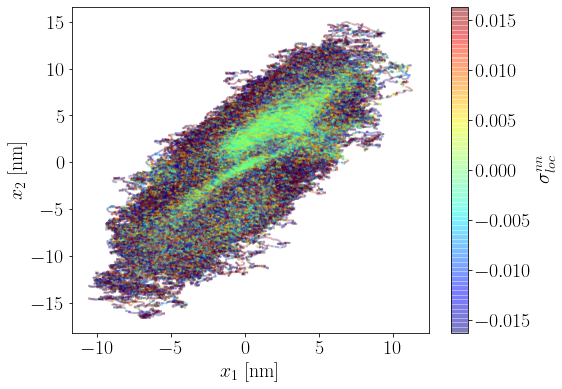

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'Times New Roman'
})




from matplotlib.collections import LineCollection
#sig = np.array(local_ep) 
sig = local_ep
fig, ax = plt.subplots(figsize=(8, 6))

nreq=n

points = np.array([xx1[:nreq,0], xx2[:nreq,0]]).T.reshape(-1, 1, 2)
#points = np.array([xx1[:-1,0], xx2[:-1,0]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

med_value = 500*np.array(torch.median(local_ep))



lc = LineCollection(segments, cmap='jet',alpha = 0.3, norm=plt.Normalize(-med_value, med_value))

lc.set_array(sig.flatten())
lc.set_linewidth(2)

# Plot    
ax.add_collection(lc)
ax.autoscale()  
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label(r'$\sigma_{loc}^{nn}$',fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.xlabel(r'$x_1$ [nm]',fontsize=20)
plt.ylabel(r'$x_2$ [nm]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('local_ep_ANN_less_data_s2.png', format='png',bbox_inches="tight" ,dpi=1200)
plt.show()


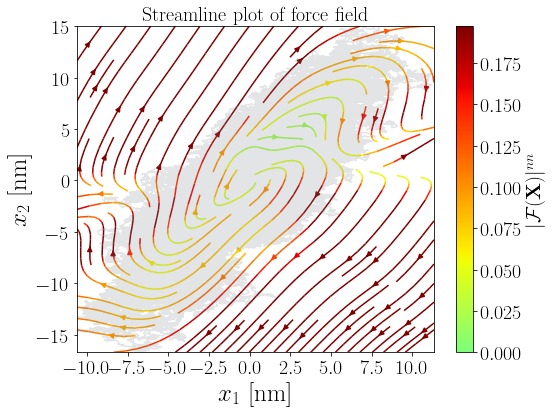

In [ ]:
# Prepare the grid for input into the network

from matplotlib.colors import ListedColormap

# Extract half of the original jet colormap
original_jet = plt.cm.get_cmap('jet', 256)  # Full jet colormap
half_jet_colors = original_jet(np.linspace(0.5, 1, 128), alpha = 1)  # Take the first half
half_jet = ListedColormap(half_jet_colors)



x_vals = np.linspace(xx1.min(), xx1.max(), 50)   
y_vals = np.linspace(xx2.min(), xx2.max(), 50)
Xg, Yg = np.meshgrid(x_vals, y_vals)



grid = np.stack([Xg.ravel(), Yg.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(dev)


with torch.no_grad():
    force_field = force_network(grid_tensor).cpu().numpy()

const_fact_ = np.array(const_fact) 

U1 = const_fact_*force_field[:, 0].reshape(Xg.shape)   # to get the force field for the data with dimension
V1 = const_fact_*force_field[:, 1].reshape(Yg.shape)



magnitude_f_ann = np.sqrt(U1**2 + V1**2)
max_val_f_ann = np.median(magnitude_f_ann)

# Plot the streamline
fig2 = plt.figure(figsize=(8, 6))
# plt.plot(x1,x2,color = '#71797E',alpha=0.2)
plt.plot(xx1[:300000,0],xx2[:300000,0],color = '#71797E',alpha=0.2)
plt.streamplot(Xg, Yg, U1, V1, color=magnitude_f_ann, cmap=half_jet, norm=plt.Normalize(0, max_val_f_ann))
#plt.streamplot(X, Y, U1, V1, color=magnitude_f_ann, cmap=half_jet, norm=plt.Normalize(0, max_val_f_ann))

plt.xlabel(r'$x_1$ [nm]',fontsize=25)
plt.ylabel(r'$x_2$ [nm]',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Streamline plot of force field', fontsize=20)
cbar = plt.colorbar(label=r'$|\mathcal{F}(\mathbf{X})|$')
cbar.set_label(r'$|\mathcal{F}(\mathbf{X})|^{nn}$', fontsize=20)
cbar.ax.tick_params(labelsize=20)
# plt.savefig('force_field_ANN_s2.png', format='png',bbox_inches="tight" ,dpi=1200)
plt.show()